In [582]:
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [583]:
### Must get the newest temp data from quikcsight when adding in a new experiment - otherwise it will not be included in the left join

In [584]:
df = pd.read_csv('Temperature_Close_to_1702073724431.csv')
df['time'] = pd.to_datetime(df['time'])

experiment_csvs = ['exp1vel.csv', 'exp2vel.csv', 'exp3vel.csv', 'exp4vel.csv', 'exp5vel.csv']

##experiment 4 is an outlier because the temp sensor was underneath the tube

experiment_data = []

for filename in experiment_csvs:
    file = open("/Users/owainpill/Documents/GitHub/SiotDataAnalysis/graphing/"+filename, "r")
    data = list(csv.reader(file, delimiter=","))
    experiment_data.append(data)
    file.close()

# for filename in os.listdir('/Users/owainpill/Documents/GitHub/SiotDataAnalysis/imageprocessing/processedimages'):

In [585]:
##convert list of lists to dataframe

velocity_values = []
corresponding_timestamps = []

for experiment in experiment_data:
    # print(experiment)
    for value in experiment:
        # print(value)
        velocity_values.append(value[::2])
        corresponding_timestamps.append(pd.to_datetime(value[1::2]))

velocity_values = [item for sublist in velocity_values for item in sublist]#flatten list of lists
corresponding_timestamps = [item for sublist in corresponding_timestamps for item in sublist]
print(velocity_values)

experiment_df = pd.DataFrame(
    {'velocity': velocity_values,
     'timestamp': corresponding_timestamps
    })

['-10.346428571428573', '-10.267240612003745', '-2.926045883940621', '-0.5855507468937596', '0.518224412802726', '-10.921428571428573', '-11.498508853681267', '-10.9952935694315', '-10.217645231438336', '-9.269602387932695', '-7.600925309546', '-4.79905813731115', '-1.1396344778697718', '-0.6424179745608315', '-10.505952380952381', '-10.256498673740055', '-10.339978593699103', '-8.492857142857142', '-6.10294968189705', '-2.5953511098701663', '-0.8137512215552145', 'nan', '-7.61604938271605', '-9.710330866955188', '-7.647530288909599', '-7.044240669240669', '-0.2777176457627586', '0.015687095723393326', '-8.011111111111111', '-10.144669365721999', '-8.918409418772393', '-6.426833976833977', '-3.1674066924066926']


In [586]:
### round timestamp to nearest minute to join with temperature data

experiment_df['timestamprounded'] = experiment_df['timestamp'].dt.round('min')

In [587]:
### join with temperature data to see effect of temperature-time on curing

df_joined = pd.merge(df, experiment_df, how='left', left_on='time', right_on='timestamprounded')
df_joined = df_joined.iloc[::-1] #reverse order of rows so that earliest time is first
df_joined = df_joined.reset_index(drop=True)

In [588]:
# df_joined = df_joined.assign(temptosum=None)
# index_at_last = 0

# for index, row in df_joined.iterrows():
#     if not pd.isnull(row['timestamprounded']) and index_at_last < 45:
#         time_at_last = row['timestamprounded']
#         # df_joined.at[index-10, 'temptosum'] = row['tempnear']
#         df_joined.loc[index-15, 'temptosum'] = df_joined.loc[index-15, 'tempnear']
#         #print(row)

# index_at_last = 0

# for index, row in df_joined.iterrows():
#     if not pd.isnull(row['timestamprounded']) and index_at_last < 45:


# for index, row in df_joined.iterrows():
#     if not pd.isnull(row['temptosum']):
#         print(row['temptosum'])
#         print(row)

# df_joined

In [589]:
# df_joined = df_joined.assign(temptosum=None)

# sum_temp_flag = False

# for index, row in df_joined.iterrows():
#     if sum_temp_flag == True:
#         df_joined.loc[index, 'temptosum'] = row['tempnear']
#         sum_temp_flag = False
#     elif not pd.isnull(df_joined.loc[index+12, 'timestamprounded']):

In [590]:
## add to each row the time of the next printer rotation

df_joined = df_joined.assign(timeatnext=None)


for index, row in df_joined.iterrows():
    if not pd.isnull(row['timestamprounded']):
        for index2, row2 in df_joined.iterrows():
            if index2 > index and not pd.isnull(row2['timestamprounded']):
                df_joined.loc[index, 'timeatnext'] = row2['timestamprounded']
                break

In [591]:
df_joined = df_joined.assign(temptosum=None)

sum_temp_flag = False

# for index, row in df_joined.iterrows():
#     try:
#         print(df_joined.loc[index+12, 'timeatnext'] - df_joined.loc[index+12, 'timestamprounded'])
#         print(pd.Timedelta(minutes=45))
#         if row['timeatnext'] - row['timestamprounded'] > pd.Timedelta(minutes=45):
#             sum_temp_flag = False
#             print('eheh')
#         elif sum_temp_flag == True:
#             df_joined.loc[index, 'temptosum'] = row['tempnear']
#             sum_temp_flag = False
#         elif df_joined.loc[index+12, 'timeatnext'] - df_joined.loc[index+12, 'timestamprounded'] < pd.Timedelta(minutes=45):
#             sum_temp_flag = True
#             print('eheheheeh')
#     except:
#         pass

df_joined = df_joined.assign(temptosum=None)
df_joined = df_joined.assign(experimentactive=None)


for index, row in df_joined.iterrows():
    try:
        # print(df_joined.loc[index+12, 'timeatnext'] - df_joined.loc[index+12, 'timestamprounded'])
        # print(pd.Timedelta(minutes=45))
        
        if df_joined.loc[index, 'timeatnext'] - df_joined.loc[index, 'timestamprounded'] < pd.Timedelta(minutes=45):
            sum_temp_flag = True
            print('eheheheeh')
        else:
            sum_temp_flag = False
        # if row['timeatnext'] - row['timestamprounded'] > pd.Timedelta(minutes=45):
        #     sum_temp_flag = False
        #     print('eheh')
        
    except:
        pass

    if sum_temp_flag == True:
            df_joined.loc[index, 'temptosum'] = row['tempnear']
            df_joined.loc[index, 'experimentactive'] = 1


for index, row in df_joined.iterrows():
    try:
        if not pd.isnull(df_joined.loc[index+12, 'temptosum']):
            df_joined.loc[index, 'temptosum'] = row['tempnear']
            df_joined.loc[index, 'experimentactive'] = 1
        if not pd.isnull(row['timestamprounded']):
            df_joined.loc[index, 'temptosum'] = row['tempnear']
            df_joined.loc[index, 'experimentactive'] = 1
    except:
        ValueError, KeyError


##unlucky case where there is a sensor outage near the very beginning of the experiment
for index,row in df_joined.iterrows():
    try:
        if row['experimentactive'] != 1 and df_joined.loc[index-1, 'experimentactive'] == 1 and df_joined.loc[index+1, 'experimentactive'] == 1:
            df_joined.loc[index, 'experimentactive'] = df_joined.loc[index-1, 'experimentactive']
    except:
        ValueError, KeyError

## interpolate where there were sensor outages
for index,row in df_joined.iterrows():
    try:
        if pd.isnull(row['temptosum']) and row['experimentactive'] == 1:
            df_joined.loc[index, 'temptosum'] = df_joined.loc[index-1, 'temptosum']
    except:
        ValueError, KeyError

## this is filling in some nan gaps but also avergaing everything together which is not desired
# for index, row in df_joined.iterrows():
#     try:
#         if not pd.isnull(df_joined.loc[index-1, 'temptosum']) and not pd.isnull(df_joined.loc[index+1, 'temptosum']):
#             df_joined.loc[index, 'temptosum'] = (df_joined.loc[index-1, 'temptosum'] + df_joined.loc[index+1, 'temptosum'])/2
#     except:
#         ValueError, KeyError

### fills in everything - not desired
# for index,row in df_joined.iterrows():
#     try:
#         if pd.isnull(row['temptosum']):
#             df_joined.loc[index, 'temptosum'] = df_joined.loc[index-1, 'temptosum']
#     except:
#         ValueError, KeyError

        
# df_joined['temptosum'] = df_joined['temptosum'].interpolate(method='linear', limit=2, limit_direction='both')

# for index, row in df_joined.iterrows():
#     if not pd.isnull(row['temptosum']):
#         # print(row['temptosum'])
#         # print(row)

eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh
eheheheeh


In [592]:
df_joined = df_joined.assign(tempsummed=0)


for index,row in df_joined.iterrows():
    try:
        df_joined.loc[index,'tempsummed'] = df_joined.loc[index-1,'tempsummed'] + df_joined.loc[index,'temptosum']
    except:
        ValueError, KeyError

/var/folders/6n/df4bbytx0tqfkq05t0fhwb080000gn/T/ipykernel_59610/824787195.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14.099999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_joined.loc[index,'tempsummed'] = df_joined.loc[index-1,'tempsummed'] + df_joined.loc[index,'temptosum']


ghadf
ghadf
ghadf
ghadf


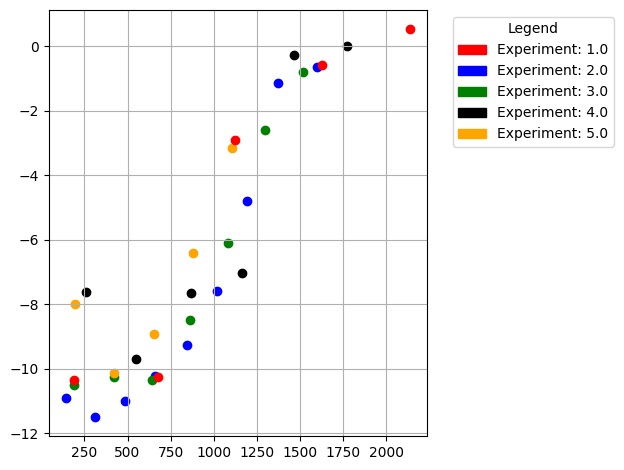

In [593]:
# columns = ['A', 'B', 'C']  # Example column names
# empty_df = pd.DataFrame(columns=columns)

columns = ['time', 'velocity', 'heattime']
df_heattime = pd.DataFrame(columns=columns)

for index,row in df_joined.iterrows():
    if not pd.isnull(row['timestamprounded']):
        # df.loc[i] = ['name' + str(i)] + list(randint(10, size=2))
        df_heattime.loc[index] = [row['timestamprounded'], row['velocity'], row['tempsummed']]


df_heattime['velocity'] = df_heattime['velocity'].astype(float)
df_heattime['heattime'] = df_heattime['heattime'].astype(float)
df_heattime['time'] = pd.to_datetime(df_heattime['time'])

df_heattime = df_heattime.sort_values(by=['time'])
df_heattime = df_heattime.reset_index(drop=True)


counter = 0
### assign different identifier to each experiment
for index,row in df_heattime.iterrows():
    try:  
        df_heattime.loc[index, 'experiment'] = counter
        if df_heattime.loc[index+1, 'time'] - df_heattime.loc[index, 'time'] > pd.Timedelta(minutes=45):
            counter += 1
            print('ghadf')
    except:
        ValueError, KeyError

## specify the color for each exerpiment - will always need to be updated
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3: 'black', 4: 'orange', 5: 'purple', 6: 'pink', 7: 'yellow', 8: 'brown', 9: 'grey'}

df_heattime['experimentcolor'] = df_heattime['experiment'].map(color_dict)


for color,subset in df_heattime.groupby('experimentcolor'):
    plt.scatter(subset['heattime'], subset['velocity'], color=color)  


# unique_values = df['Values'].unique()
# legend_handles = [mpatches.Patch(color=plt.cm.viridis(i / len(unique_values)), label=f'Value: {value}') for i, value in enumerate(unique_values)]
# plt.legend(handles=legend_handles, title='Legend', loc='upper right')
unique_values = df_heattime['experiment'].unique()
legend_handles = [mpatches.Patch(color=color_dict[i], label=f'Experiment: {value+1}') for i, value in enumerate(unique_values)]
plt.legend(handles=legend_handles, title='Legend', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.grid(True)

In [594]:
df_heattime.to_csv('df_heattime.csv', index=False)